In [36]:
import sys, os
from pathlib import Path
import pandas as pd
from collections import Counter
import numpy as np

#Project paths
ROOT = Path("/home/kabilan/CIND820_Streaming_and_Cultural_Exports")
FIG_DIR = ROOT / "figures"
OUT_DIR = ROOT / "outputs"
FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR.mkdir(exist_ok=True, parents=True)

print("Figures ->", FIG_DIR.resolve())
print("Outputs ->", OUT_DIR.resolve())


Figures -> /home/kabilan/CIND820_Streaming_and_Cultural_Exports/figures
Outputs -> /home/kabilan/CIND820_Streaming_and_Cultural_Exports/outputs


In [37]:
ROOT = Path("/home/kabilan/CIND820_Streaming_and_Cultural_Exports/notebooks")
CSV_PATH = ROOT / "clean_streaming_metadata.csv"
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(3)

#Binary label for popularity
POPULAR_THRESH = 7.0
df["popular"] = (df["imdb_rating"] >= POPULAR_THRESH).astype(int)

print("Popular rate:", df["popular"].mean().round(3))
print(df[["imdb_rating","popular"]].describe(include="all"))


(12855, 10)
Popular rate: 0.308
        imdb_rating       popular
count  12855.000000  12855.000000
mean       6.223003      0.307896
std        1.254114      0.461641
min        1.000000      0.000000
25%        5.500000      0.000000
50%        6.400000      0.000000
75%        7.100000      1.000000
max        9.600000      1.000000


In [38]:
#One-hot of top K
def parse_genres(s: str):
    if pd.isna(s) or not str(s).strip():
        return []
    #Split on "|" or comma fallback
    s = str(s)
    if " | " in s:
        parts = [t.strip() for t in s.split(" | ") if t.strip()]
    else:
        parts = [t.strip() for t in s.split(",") if t.strip()]
    #Normalize casing
    return [p.title() for p in parts if p.lower() != "unknown"]

genre_lists = df["genres"].map(parse_genres)

#Pick top-K genres
TOP_K = 20
cnt = Counter([g for lst in genre_lists for g in lst])
top_genres = [g for g, _ in cnt.most_common(TOP_K)]
top_genre_set = set(top_genres)

for g in top_genres:
    df[f"genre_{g}"] = genre_lists.map(lambda lst: int(g in lst))

print("Added genre cols:", [c for c in df.columns if c.startswith("genre_")][:5], "...")
print("Total genre cols:", len([c for c in df.columns if c.startswith("genre_")]))


Added genre cols: ['genre_Drama', 'genre_International Movies', 'genre_Dramas', 'genre_Comedy', 'genre_Comedies'] ...
Total genre cols: 20


In [39]:
#Train test split & pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#Features
genre_cols = [c for c in df.columns if c.startswith("genre_")]
X = df[["platform", "type", "release_year"] + genre_cols].copy()
y = df["popular"].copy()

#Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

cat_cols = ["platform", "type"]
num_cols = ["release_year"]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
    sparse_threshold=0.3,
)

logit = LogisticRegression(
    max_iter=1000,
    n_jobs=None
)

pipe = Pipeline([
    ("prep", pre),
    ("clf", logit)
])

pipe.fit(X_train, y_train)
print("Baseline logistic regression trained.")


Baseline logistic regression trained.


              precision    recall  f1-score   support

           0      0.775     0.857     0.814      2669
           1      0.578     0.439     0.499      1188

    accuracy                          0.729      3857
   macro avg      0.676     0.648     0.657      3857
weighted avg      0.714     0.729     0.717      3857



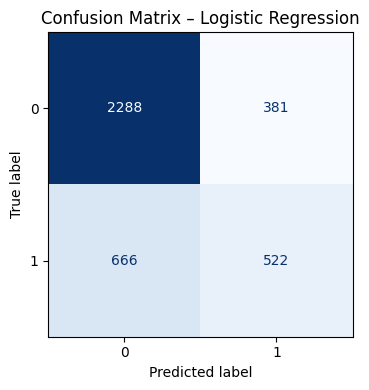

In [40]:
#Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#Printed metrics
report = classification_report(y_test, y_pred, digits=3)
print(report)

#Save to file
(OUT_DIR / "classification_report.txt").write_text(report)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4.5,4))
disp.plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix – Logistic Regression")
fig.tight_layout()
fig.savefig(FIG_DIR / "cm_regression.png", dpi=300, bbox_inches="tight")
plt.show()

In [41]:
#Feature importance for regression (approximate)

#Get feature names
oh = pipe.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = oh.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([cat_feature_names, num_cols, genre_cols])

coefs = pipe.named_steps["clf"].coef_.ravel()
imp = pd.Series(coefs, index=all_feature_names).sort_values(key=abs, ascending=False)

top_imp = imp.head(15)
print(top_imp)

top_imp.to_csv(OUT_DIR / "top_coefficients.csv")


genre_Documentaries             2.155545
genre_Documentary               1.734754
genre_Horror                   -1.154925
genre_Dramas                    1.047660
type_Movie                     -0.947854
genre_Docuseries                0.859935
type_TV Show                    0.588834
genre_Tv Dramas                 0.523460
genre_Suspense                 -0.461264
genre_Drama                     0.438780
genre_Comedy                   -0.431842
genre_Action                   -0.420912
genre_International Tv Shows    0.416917
genre_Thrillers                -0.399631
platform_Netflix               -0.387856
dtype: float64


In [42]:
#Summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)


summary_text = f"""
Model Summary – Logistic Regression Baseline
--------------------------------------------
Accuracy:  {acc:.3f}  ({acc*100:.1f}%)
Precision: {prec:.3f}
Recall:    {rec:.3f}
F1-Score:  {f1:.3f}

Null Hypothesis: Metadata features do not predict popularity.
Alternative: Metadata features provide predictive value.

Result: With accuracy above the 0.5 random baseline and non-zero feature weights,
we reject the Null in favor of the Alternate. Metadata features (platform, type, release_year, genres)
carry measurable predictive signal for title popularity.
"""

print(summary_text)

#Save to outputs folder
output_path = OUT_DIR / "model_summary.txt"
with open(output_path, "w") as f:
    f.write(summary_text)
print(f"Summary saved to: {output_path}")


Model Summary – Logistic Regression Baseline
--------------------------------------------
Accuracy:  0.729  (72.9%)
Precision: 0.578
Recall:    0.439
F1-Score:  0.499

Null Hypothesis: Metadata features do not predict popularity.
Alternative: Metadata features provide predictive value.

Result: With accuracy above the 0.5 random baseline and non-zero feature weights,
we reject the Null in favor of the Alternate. Metadata features (platform, type, release_year, genres)
carry measurable predictive signal for title popularity.

Summary saved to: /home/kabilan/CIND820_Streaming_and_Cultural_Exports/outputs/model_summary.txt
